In [157]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
from gwbench import Network, injections_CBC_params_redshift
import pandas as pd
import deepdish as dd
import os
import numpy as np
import pylab as plt
from glob import glob
from tqdm import tqdm
import seaborn as sns

## Get injection data

In [154]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
inj_data_file = os.path.join(base_dir, 'SNR_output_files', 'BBH', 
                             'LHI_SNR_1_pop_PLP_spin_prec_z_MD_zmax_6_lmrd_22_365_days_corrected_td_SNR_data.h5')

In [155]:
inj_data = dd.io.load(inj_data_file)

In [112]:
inj_data['Optimal_SNR'].keys()

Index(['PSD_L1', 'PSD_H1', 'PSD_I1', 'spin1_a', 'spin2_a', 'chi_eff', 'chi_p',
       'mchirp', 'srcmchirp', 'cos_spin1_polar', 'cos_spin2_polar', 'srcmass1',
       'srcmass2', 'q', 'spin1_azimuthal', 'spin2_azimuthal', 'redshift',
       'eta', 'spin1_polar', 'spin2_polar', 'mtotal', 'srcmtotal',
       'chi_1_in_plane', 'chi_2_in_plane', 'phi_12', 'phi_jl', 'theta_jn',
       'time_interval', 'inclination', 'distance', 'mass1', 'mass2',
       'coa_phase', 'f_ref', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y',
       'spin2z', 'approximant', 'f_lower', 'delta_f', 'f_final', 'dec',
       'trigger_time', 'polarization', 'ra', 'SNR_L1', 'SNR_H1', 'SNR_I1',
       'SNR_network'],
      dtype='object')

In [113]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, method='network', return_detected_dict=False):
    SNR_keys = [key for key in data_dict.keys() if 'SNR' in key]
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        dict_key = key.split('SNR_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

In [114]:
inj_data['detected'] = get_detected_SNRs(inj_data['Optimal_SNR'], method='two-detector')

#### Choose n_events from detected as injection parameters

In [115]:
n_events = 500
inj_data['selected_n_events'] = inj_data['detected'].sample(n_events, random_state=123).sort_index()

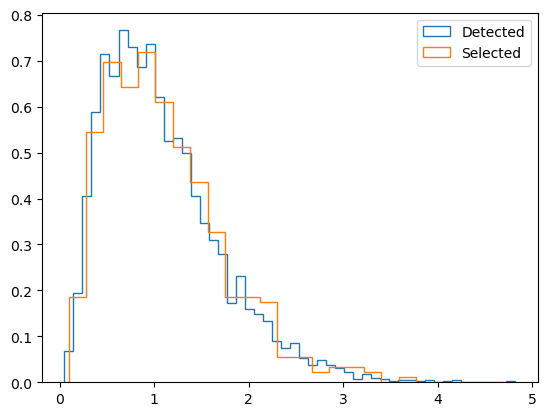

In [116]:
plt.hist(inj_data['detected']['redshift'], density=True, histtype=u'step', bins=50, label='Detected')
plt.hist(inj_data['selected_n_events']['redshift'], density=True, histtype=u'step', bins=20, label='Selected');
plt.legend()

## FM analysis with GWBench

### Setup

In [117]:
fm_params_str = 'Mc eta DL iota tc phic ra dec psi'
def run_analysis(inj_params, logging_level='WARNING', num_cores=2):
    f"""
    Parameters:
    -------------------------------------------------------------
    inj_params: dict
        dict with keys: Mc, eta, tc, phic, 
                        DL, iota, ra, dec, psi, 
                        chi1x, chi1y, chi1z, chi2x, chi2y, chi2z
    Returns:
    -----------------------
    FM: matrix
        Fisher matrix with parameter order as: {fm_params_str}
    cov: matrix
        Covariance matrix corresponding to the FM
    errors: dict
        Parameter errors
    """
    wf_model_name = 'lal_bbh'
    wf_other_var_dic = {'approximant':'IMRPhenomXHM'}
    user_psds = {'A-Sharp':{'psd_file':'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/Asharp-asd.txt', 
                            'is_asd': True}}
    conv_log = ('Mc', 'DL')
    ana_deriv_symbs_string = 'DL tc phic ra dec psi'
    network_spec = ['A-Sharp_L', 'A-Sharp_H', 'A-Sharp_I']
    f_low = 5
    f_high = 1024
    df = 1/16
    f_arr = np.arange(f_low, f_high+df, df)
    net = Network(network_spec, logger_level=logging_level)
    net.set_net_vars(wf_model_name=wf_model_name, 
                     wf_other_var_dic=wf_other_var_dic,
                     f=f_arr, 
                     inj_params=inj_params,
                     deriv_symbs_string=fm_params_str,
                     ana_deriv_symbs_string=ana_deriv_symbs_string,
                     conv_log=conv_log, 
                     user_psds=user_psds)
    net.calc_errors(derivs='num', f_lo=f_low, f_hi=f_high, num_cores=num_cores)
    return(net.fisher, net.cov, net.errs, net.snr, net.deriv_variables, net.inv_err['inv_err'])

### Calculate Errors

In [118]:
gwbench_to_pycbc_map = {
    'Mc': 'mchirp',
    'eta': 'eta',
    'DL': 'distance',
    'iota': 'inclination',
    'ra': 'ra',
    'dec': 'dec',
    'psi': 'polarization',
    'chi1z': 'spin1z',
    'chi2z': 'spin2z'
}

In [138]:
inj_records = inj_data['selected_n_events'].to_records()
results = {'inj_params':[], 'cov':[], 'errs':[], 'all_inj_params_original':[]}
failed_events = {'inj_params':[]}
#for event_num in tqdm(range(3)):
for event_num in tqdm(range(len(inj_records))):
    params_i = inj_records[event_num]
    inj_params = {'chi1x': 0, 
                  'chi1y': 0,
                  'chi2x': 0,
                  'chi2y': 0,
                  'chi1z': 0,
                  'chi2z': 0}
    for param in fm_params_str.split():
        if param == 'tc' or param == 'phic':
            inj_params[param] = 0
        else:
            inj_params[param] = params_i[gwbench_to_pycbc_map[param]]
    try:
        fm, cov, errs, snr, deriv_vars, inv_err = run_analysis(inj_params, num_cores=4)
        results['inj_params'].append(inj_params)
        results['all_inj_params_original'].append({key:params_i[key] for key in params_i.dtype.names})
        errs['snr'] = snr
        errs['inv_err'] = inv_err
        results['cov'].append(cov)
        results['errs'].append(errs)
        results['deriv_variables_in_order'] = deriv_vars
    except:
        failed_events['inj_params'].append(inj_params)

XLAL Error - XLALSimIMRPhenomXHMFrequencySequence (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1734695399192/work/lib/LALSimIMRPhenomXHM.c:1656): Error: m1 must be positive and greater than 0.                                                                    | 331/500 [04:35<02:05,  1.34it/s]

XLAL Error - XLALSimIMRPhenomXHMFrequencySequence (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1734695399192/work/lib/LALSimIMRPhenomXHM.c:1656): Internal function call failed
XLAL Error - XLALSimInspiralChooseFDWaveformSequence (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1734695399192/work/lib/LALSimInspiralWaveformCache.c:1532): Internal function call failed
XLAL Error - XLALSimIMRPhenomXHMFrequencySequence (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1734695399192/work/lib/LALSimIMRPhenomXHM.c:1656): Error: m1 must be positive and greater than 0.         

XLAL Error - XLALSimIMRPhenomXHMFrequencySequence (/home/cond

### Check if cov matrices are positive-definite

In [145]:
failed = []
for event in range(499):
    cov = results['cov'][event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed.append(event)

In [146]:
failed

[]

### Add redshift to results file

In [147]:
i=0
for DL, z in zip(inj_data['selected_n_events']['distance'], inj_data['selected_n_events']['redshift']):
    if DL == failed_events['inj_params'][0]['DL']:
        print(f'Skipping event number {i}')
    else:
        results['inj_params'][i]['z'] = z
        i += 1

Skipping event number 331


Text(0.5, 0, '$\\Delta D_L / D_L$')

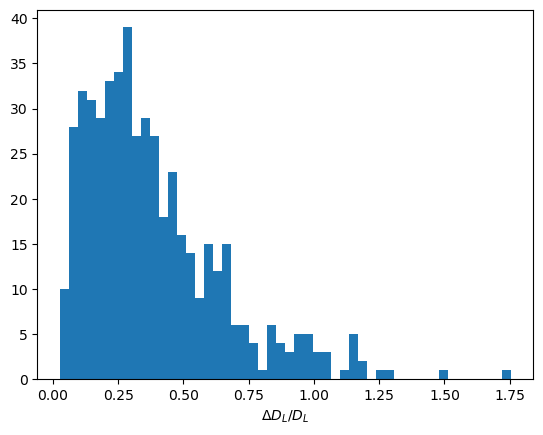

In [148]:
plt.hist([results['errs'][i]['log_DL'] for i in range(len(results['errs']))], bins=50);
plt.xlabel('$\Delta D_L / D_L$')

In [149]:
failed_events

{'inj_params': [{'chi1x': 0,
   'chi1y': 0,
   'chi2x': 0,
   'chi2y': 0,
   'chi1z': 0,
   'chi2z': 0,
   'Mc': np.float64(70.66247739577898),
   'eta': np.float64(0.24999999983424404),
   'DL': np.float64(17254.62022785116),
   'iota': np.float64(0.9433453461672721),
   'tc': 0,
   'phic': 0,
   'ra': np.float64(4.817171078649492),
   'dec': np.float64(0.7518123115904721),
   'psi': np.float64(2.761454209862496)}]}

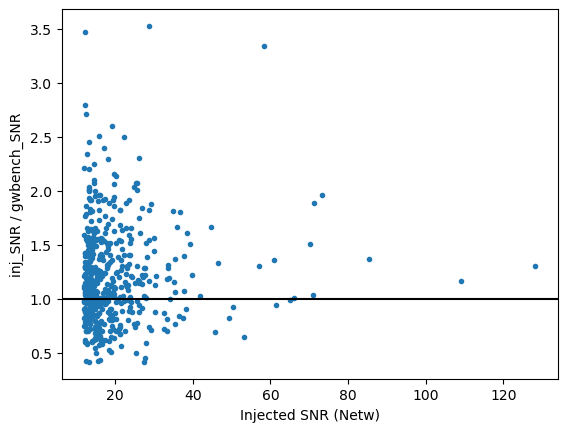

In [150]:
x = []
for i, dist, snr in zip(range(500), inj_data['selected_n_events']['distance'], inj_data['selected_n_events']['SNR_network']):
    if dist != (failed_events['inj_params'][0]['DL']):
        x.append(snr)
y = x/pd.DataFrame(results['errs'])['snr']
plt.plot(x, y, '.')
plt.xlabel('Injected SNR (Netw)')
plt.ylabel('inj_SNR / gwbench_SNR')
plt.axhline(1, c='k')

## Save to h5 file

In [151]:
def save_results_to_h5(results, filename):
    with h5py.File(filename, 'w') as f:
        # Save inj_params
        inj_params_group = f.create_group('inj_params')
        for i, param_dict in enumerate(results['inj_params']):
            param_group = inj_params_group.create_group(str(i))
            for key, value in param_dict.items():
                param_group.create_dataset(key, data=value)

        # Save cov (numpy matrices)
        cov_group = f.create_group('cov')
        for i, matrix in enumerate(results['cov']):
            cov_group.create_dataset(str(i), data=matrix)

        # Save errs
        errs_group = f.create_group('errs')
        for i, err_dict in enumerate(results['errs']):
            err_group = errs_group.create_group(str(i))
            for key, value in err_dict.items():
                err_group.create_dataset(key, data=value)

        all_inj_original_group = f.create_group('all_inj_params_original')
        for i, param_dict in enumerate(results['all_inj_params_original']):
            param_group = all_inj_original_group.create_group(str(i))
            for key, value in param_dict.items():
                param_group.create_dataset(key, data=value)

        # Save deriv_variables_in_order (list of strings)
        dt = h5py.string_dtype(encoding='utf-8')
        f.create_dataset('deriv_variables_in_order', 
                         data=np.array(results['deriv_variables_in_order'], 
                                       dtype=dt))

In [152]:
results_file = os.path.join(base_dir, 'GWBench_analysis', 'BBH',
                            'LHI_Asharp_PLP_z_MD_zmax_6_lmrd_22_no_spins.h5')
save_results_to_h5(results, results_file)

## Spot checks with MPSAC study

In [95]:
mpsac_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/Relevant_papers/Ish Gupta_et_al_data/'
mpsac_data_bbh = {}
with h5py.File(glob(os.path.join(mpsac_dir, '*', '*', '*bbh*hdf5'))[0], 'r') as file:
    i=9
    inj_params = {key:file['inj_params'][key][i] for key in file['inj_params'].keys()}
    Mc = (1+inj_params['z'])*inj_params['Mc']
    inj_params['Mc'] = Mc
    print(inj_params)
    fm, cov, errs, snr, dvars, inv_errs = run_analysis(inj_params)
    err_dict = {key:[file['networks']['HLI'][key][i], errs[key]] for key in errs.keys()}
    try:
        np.linalg.cholesky(cov)
    except Exception as e:
        print('\n', 'Error:', e)
    err_dict['source'] = ['MPSAC', 'Current analysis']
    err_df = pd.DataFrame(err_dict).set_index('source').T

{'DL': np.float64(613.0532129566052), 'Mc': np.float64(29.52608930472442), 'chi1x': np.float64(0.0), 'chi1y': np.float64(0.0), 'chi1z': np.float64(0.09757743535542235), 'chi2x': np.float64(0.0), 'chi2y': np.float64(0.0), 'chi2z': np.float64(0.13015506724064474), 'dec': np.float64(0.6005676332161993), 'eta': np.float64(0.2480576947053691), 'gmst0': np.float64(44958.217426017385), 'iota': np.float64(0.9661358753614275), 'log_DL': np.float64(6.418451739601951), 'log_Mc': np.float64(3.266043329076431), 'phic': np.float64(0.0), 'psi': np.float64(1.9138262503804069), 'ra': np.float64(1.0558372118915251), 'tc': np.float64(0.0), 'z': np.float64(0.12663005714874154)}

 Error: Matrix is not positive definite


In [96]:
err_df

source,MPSAC,Current analysis
log_Mc,0.000149,0.000226
eta,0.000487,0.000449
log_DL,0.030009,0.040938
iota,0.029717,0.046089
tc,0.000031,0.000043
phic,0.108621,0.108604
ra,0.001964,0.001815
dec,0.001257,0.002764
psi,0.031062,0.045767
chi1z,0.006382,0.002605
